# Univariate Experiments with LRHS

In [14]:
import matplotlib.pyplot as plt
import warnings
from matplotlib.ticker import ScalarFormatter
from lrhs.univariate import UnivariateExperiment
from lrhs.blrhs import set_fonts
set_fonts(15,16)

To replicate the experiments from the main paper, please download the datasets from the link, which contains the public datasets described in the paper as prepared for our experiments: https://drive.google.com/file/d/1YPOR98eMDbYk3RlIO5Jp0AaQiW2E2bDx/view?usp=sharing. Afterwards, place the downloaded .zip file to the root folder of this repository, and run the command below. This command will extract the six univariate data folders under `data/univariate/`.

In [ ]:
!mkdir data/univariate/
!unzip univariate_datasets.zip -d data/univariate/

The cell below conducts the univariate experiments in the main paper for a chosen experiment setting. The parameters are mostly self explanatory: `dataset_name` determines the name of the dataset that will be used, `folds` determines whether yearly seasonality will be included or not, and `nr_in_cycles` determines the number of full cycles to be used as the training data; all remaining data automatically becomes the test data. The dictionary `experiments` provide the settings described in the main paper, from among which the user select by setting the `experiment` variable.

In [3]:
# electricity = 21000 hours, 125 days
# traffic = 13944 hours, 83 days
# bart = 78624 hours, 468 weeks, 9 years
# energy = 104832 hours, 624 weeks, 12 years

experiments = {
    "energy": {"dataset_name": "kaggle_energy", "nr_in_cycles":614,"folds":(24, 7)},
    "energy_1y": {"dataset_name": "kaggle_energy", "nr_in_cycles":11,"folds":(24, 7,52)},
    "bart": {"dataset_name": "kaggle_bart", "nr_in_cycles":458,"folds":(24, 7)},
    "bart_1y": {"dataset_name": "kaggle_bart", "nr_in_cycles":8,"folds":(24, 7, 52)},
    "traffic_75": {"dataset_name": "traffic_75", "nr_in_cycles":73,"folds":(24, 7)},
    "traffic_85": {"dataset_name": "traffic_85", "nr_in_cycles":73,"folds":(24, 7)},
    "electricity_75": {"dataset_name": "electricity_75", "nr_in_cycles":115,"folds":(24, 7)},
    "electricity_85": {"dataset_name": "electricity_85", "nr_in_cycles":115,"folds":(24, 7)}
}

experiment = "electricity_75"

ts_experiments = UnivariateExperiment(
    dataset_name=experiments[experiment]["dataset_name"],
    folds=experiments[experiment]["folds"],
    nr_in_cycles=experiments[experiment]["nr_in_cycles"],
    n_jobs=4,
    methods=['DCTForecaster', 'DFTForecaster','FourierBasisRegressionForecaster',
                'HoltWintersForecaster', 'CPForecaster', 'SmoothingCPForecaster',
                'TuckerForecaster','SmoothingTuckerForecaster'],
    dataset_path="data/univariate/"
)
results = ts_experiments.run()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mean_errors = results.groupby(["dataset", "experiment_id", "model", "nr_params"])["in_rmse", "in_mad", "out_rmse", "out_mad"].mean()

100%|██████████| 236/236 [12:14<00:00,  3.11s/it]


## Visualizing experiment results

The code below conducts a visualization of the results in terms of errors vs. number of parameters for all models, for the experiment setting defined above.

In [11]:
models = ["DCT", "DFT", "FB", "HW", "LRHS-CP", "LRHS-CP-S", "LRHS-T", "LRHS-T-S"]
metrics_title = {"in_mad": "MAE (In Sample)", "in_rmse": "RMSE (In Sample)",  "out_mad": "MAE (Out of Sample)",  "out_rmse": "RMSE (Out of Sample)"}
styles = {"DCT": "-.b", "DFT": "--y", "FB": "-.g", "HW": "--c", "LRHS-CP": "o-m", "LRHS-CP-S": "x:m", "LRHS-T": "o-r", "LRHS-T-S": "x:r"}
metrics = ["in_mad", "in_rmse", "out_mad", "out_rmse"]

results["dataset_rem_name"] = experiment
model_rename = dict(
    zip(
        ['DCTForecaster', 'DFTForecaster', 'FourierBasisRegressionForecaster', 'HoltWintersForecaster',
         'CPForecaster', 'SmoothingCPForecaster', 'TuckerForecaster', 'SmoothingTuckerForecaster'],
        models
    )
)
results['model'] = results['model'].replace(model_rename)
all_by_pars = results.groupby(
    ["dataset_rem_name", "model", "experiment_id", "num_params"]
)[metrics].mean()

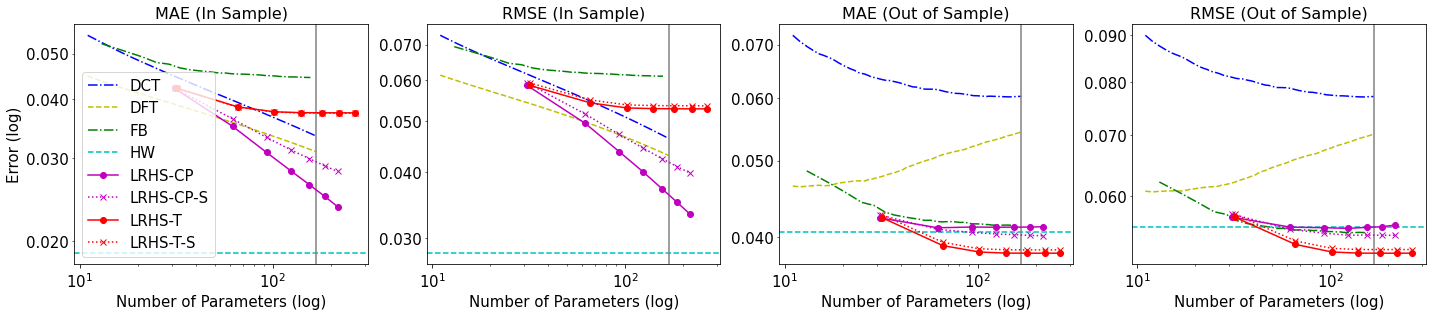

In [15]:
df = all_by_pars.reset_index()
df = df.query("num_params > 10")
fig, axes = plt.subplots(1,4,figsize=(20,4.5),sharex=True)
for i, metric in enumerate(metrics):
    ax = axes[i]
    for model in models:
        df_temp = df.query(f"dataset_rem_name == '{experiment}' and model == '{model}'")[["num_params", metric]]
        if model == "HW":
            ax.axhline(df_temp.iloc[0][metric], linestyle="--", color="c", label=model)
            ax.axvline(df_temp.iloc[0]["num_params"], color="gray")
        else:
            ax.plot(df_temp["num_params"], df_temp[metric], styles[model], label=model)
    ax.semilogx(); ax.semilogy()
    ax.yaxis.set_major_formatter(ScalarFormatter()); ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    if i == 0:
        ax.set_ylabel("Error (log)")
    ax.set_xlabel("Number of Parameters (log)")
    ax.set_title(metrics_title[metric])
axes[0].legend()
fig.tight_layout()
# fig.savefig(f"img/univariate/{'_'.join(dataset_rem_name.split('_')[:-1])}_params.pdf", format="pdf", bbox_inches="tight")